# Imports

In [1]:
# imports

import os
import numpy as np
import random
import pandas as pd
import json
import pickle
import matplotlib.pyplot as plt
from utils import *

# Import and split data

In [2]:
# define file directory
directory = '../data/interim/PatternNet/images'

# create a list of all possible classes
all_classes = []
for item in os.listdir(directory):
    item_path = os.path.join(directory, item)
    if os.path.isdir(item_path):
        all_classes.append(item)
#print(all_classes)
        
# create a list of classes considered for this project
classes = ['beach', 'chaparral', 'dense_residential', 'forest', 'freeway', 'harbor', 'overpass', 'parking_space', 'river', 'swimming_pool']
        
# inspect the number of images per class
data = []
for class_name in classes:
    class_dir = os.path.join(directory, class_name)
    image_count = len(os.listdir(class_dir))
    data.append([class_name, image_count])
image_count_df = pd.DataFrame(data, columns=['Class', 'Total Image Count'])
print("The following classes were selected for evaluation:")
display(image_count_df)

# define the train, val, and test sets
train_files, val_files, test_files = generate_splits(classes, directory)

The following classes were selected for evaluation:


,Class,Total Image Count
0,beach,800
1,chaparral,800
2,dense_residential,800
3,forest,800
4,freeway,800
5,harbor,800
6,overpass,800
7,parking_space,800
8,river,800
9,swimming_pool,800


train/validation/test subsets were loaded from a pre-generated file
	Number of train files: 4799
	Number of val files: 1599
	Number of test files: 1601


# Inspect examples

In [3]:
def fft_image(image):

    # Read the image
    # image = plt.imread(image)

    # Convert the image to grayscale if it's not already
    if len(image.shape) > 2:
        image_gray = np.mean(image, axis=2)
    else:
        image_gray = image

    ydim, xdim = image_gray.shape
    win = np.outer(np.hanning(ydim),np.hanning(xdim))
    win = win/np.mean(win)
    
    # Compute the 2D FFT of the grayscale image
    fft_image = np.fft.fft2(image_gray*win)

    # Shift the zero frequency component to the center
    fft_image_shifted = np.fft.fftshift(fft_image)

    # Compute the magnitude spectrum (absolute value) of the shifted FFT
    magnitude_spectrum = np.abs(fft_image_shifted)
    
    return magnitude_spectrum


In [4]:
def bandpass_filter(image, low_cutoff, high_cutoff):
    # Convert the image to grayscale if it's not already
    if len(image.shape) > 2:
        image_gray = np.mean(image, axis=2)
    else:
        image_gray = image
   
    # Compute the 2D FFT of the image
    fft_image = np.fft.fft2(image_gray)
    fft_shifted = np.fft.fftshift(fft_image)
    
    # Create a mask for the bandpass filter
    rows, cols = image_gray.shape
    mask = np.zeros((rows, cols), np.uint8)
    center = (rows // 2, cols // 2)
    mask[int(center[0] - high_cutoff):int(center[0] + high_cutoff), int(center[1] - high_cutoff):int(center[1] + high_cutoff)] = 1
    mask[int(center[0] - low_cutoff):int(center[0] + low_cutoff), int(center[1] - low_cutoff):int(center[1] + low_cutoff)] = 0
    
    # Apply the mask to the frequency domain representation
    fft_shifted_filtered = fft_shifted * mask
    
    # Compute the inverse 2D FFT
    ifft_shifted_filtered = np.fft.ifftshift(fft_shifted_filtered)
    filtered_image = np.fft.ifft2(ifft_shifted_filtered)
    filtered_image = np.abs(filtered_image)
    
    return filtered_image.astype(np.uint8)


In [5]:
def apply_low_pass_filter(image, cutoff_frequency):
        # Convert the image to grayscale if it's not already
    if len(image.shape) > 2:
        image_gray = np.mean(image, axis=2)
    else:
        image_gray = image
    
    # Compute FFT of the image
    f_transform = np.fft.fft2(image_gray)
    
    # Shift zero frequency component to center
    f_transform_shifted = np.fft.fftshift(f_transform)
    
    # Get size of the image
    rows, cols = image_gray.shape
    
    # Generate a Gaussian filter with the same size as the image
    gaussian_filter = np.zeros((rows, cols), np.float32)
    for i in range(rows):
        for j in range(cols):
            distance = np.sqrt((i - rows/2)**2 + (j - cols/2)**2)
            gaussian_filter[i, j] = np.exp(-(distance**2) / (2*(cutoff_frequency**2)))
    
    # Apply the Gaussian filter to the frequency domain image
    filtered_f_transform_shifted = f_transform_shifted * gaussian_filter
    
    # Shift zero frequency component back to corners
    filtered_f_transform = np.fft.ifftshift(filtered_f_transform_shifted)
    
    # Compute inverse FFT to obtain filtered image
    filtered_image = np.abs(np.fft.ifft2(filtered_f_transform))
    
    return filtered_image.astype(np.uint8)


In [85]:
# define a function to show a grid of spectrum images in a directory (given a file subset)
def generate_freq_spectrum(files, directory, images_per_class=3):
    # create a dictionary to store class images
    class_images = {}
    
    # iterate over each file
    for class_name, file_name in files:
        # load the image
        img = plt.imread(os.path.join(directory, class_name, file_name))
        # if class not in dictionary, initialize empty list
        if class_name not in class_images:
            class_images[class_name] = []
        # append image to class list
        class_images[class_name].append(img)

    # create a grid of images
    metrics_dict = {}
    metrics_dict2 = {}
    count = 0
    num_classes = len(class_images)
    fig, axes = plt.subplots(num_classes, images_per_class + 1, figsize=(12, 3*num_classes))
    for i, (class_name, images) in enumerate(class_images.items()):
        # display class name in the first column
        axes[i, 0].text(0.5, 0.5, class_name, fontsize=16, ha='center', va='center')
        axes[i, 0].axis('off')

        # display random images in the subsequent columns
        random.shuffle(images)
        for j in range(images_per_class):
            low_cutoff = 0
            high_cutoff = 20
            filtered_image = bandpass_filter(images[j], low_cutoff, high_cutoff)

            magnitude_spectrum = fft_image(images[j])
            spec = np.log(1+magnitude_spectrum).ravel()
            metrics_dict[count] = {'name': class_name, 'min': spec.min(), 'max': spec.max(), \
                                   'mean': spec.mean(), 'stddev': spec.std(), 'median': np.median(spec), 'range': spec.max()-spec.min()}
            
            magnitude_spectrum = fft_image(filtered_image)
            spec = np.log(1+magnitude_spectrum).ravel()
            metrics_dict2[count] = {'name': class_name, 'min': spec.min(), 'max': spec.max(), \
                                   'mean': spec.mean(), 'stddev': spec.std(), 'median': np.median(spec), 'range': spec.max()-spec.min()}
            
            #print(class_name, spec.min(), spec.max(), spec.mean(), spec.std(), np.median(spec))
            #axes[i, j+1].hist(np.log(1 + magnitude_spectrum).ravel(), bins=100)
            #axes[i, j+1].imshow(np.log(1 + magnitude_spectrum), cmap='gray')
            # axes[i, j+1].imshow(images[j], cmap='gray')
            axes[i, j+1].imshow(filtered_image, cmap='gray')

            count += 1

    df = pd.DataFrame(metrics_dict)
    df2 = pd.DataFrame(metrics_dict2)

    plt.tight_layout()
    plt.show()
    
    return df, df2

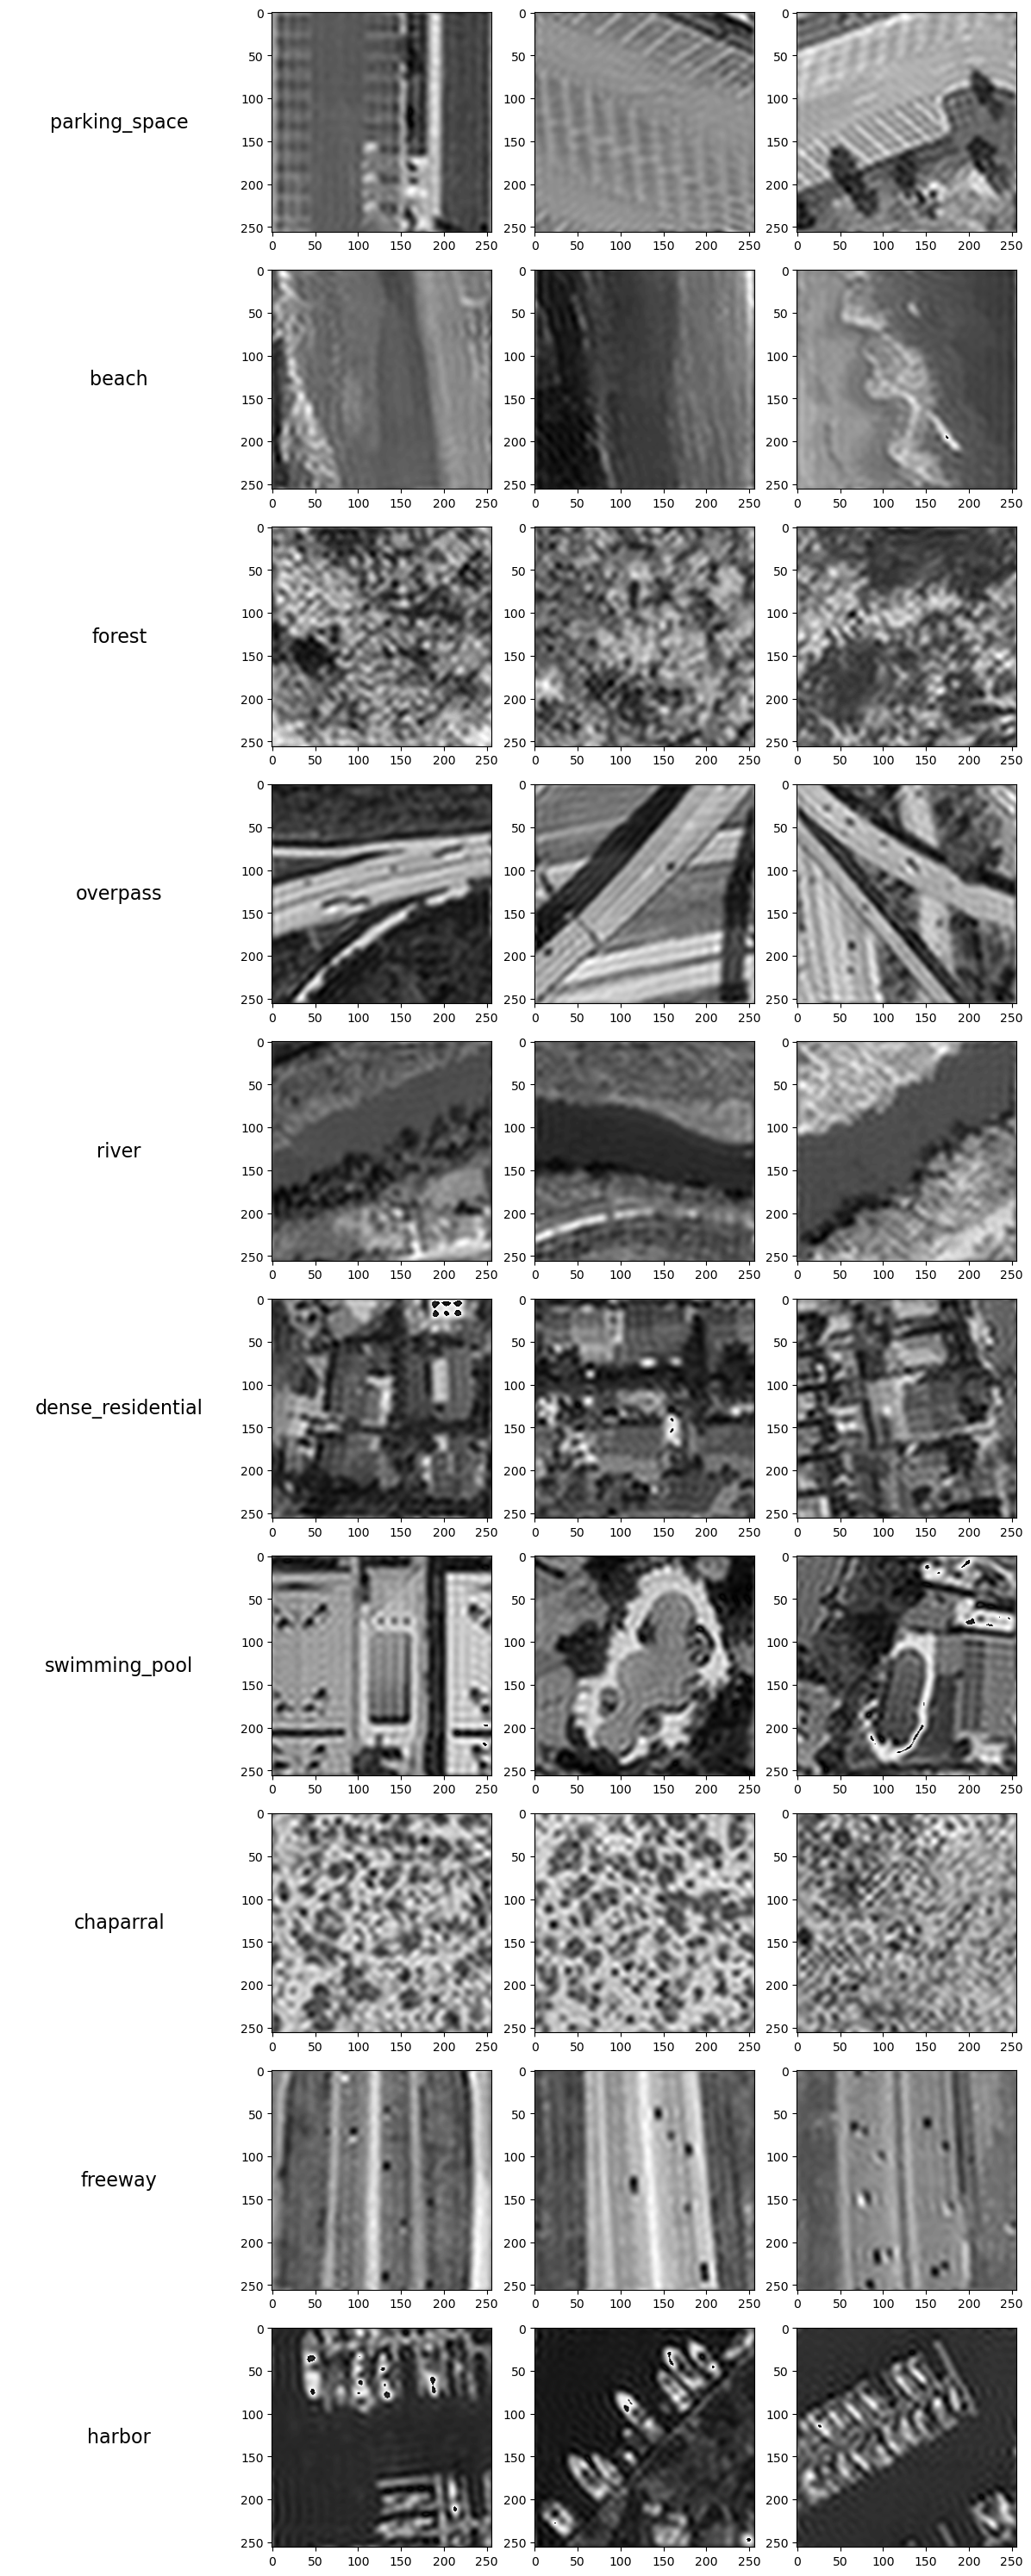

In [86]:
# show a grid with 3 random images per class
df, df2 = generate_freq_spectrum(train_files, directory, 3)

In [87]:
df = df.transpose()
df2 = df2.transpose()

In [88]:
df

,name,min,max,mean,stddev,median,range
0,parking_space,1.624234,15.411501,7.267847,1.264716,7.066276,13.787267
1,parking_space,0.701983,15.997176,6.475954,1.27659,6.312519,15.295193
2,parking_space,1.279478,15.834242,7.616279,1.118474,7.529724,14.554764
3,beach,1.73081,15.826668,6.827572,1.001954,6.83967,14.095858
4,beach,0.898854,15.785611,6.477988,1.05117,6.39694,14.886757
5,beach,1.834702,15.905709,7.517559,1.329003,7.395679,14.071006
6,forest,2.659873,14.515171,7.782414,1.033227,7.766857,11.855298
7,forest,2.532645,14.955811,7.830299,1.073139,7.806659,12.423166
8,forest,2.450984,14.645758,7.759562,1.032614,7.756239,12.194774
9,overpass,2.373944,15.761826,7.489333,1.229349,7.390437,13.387882


In [89]:
df2

,name,min,max,mean,stddev,median,range
0,parking_space,0.37144,15.405319,4.801558,1.135272,4.71962,15.033879
1,parking_space,0.495081,15.993488,4.563255,0.968328,4.560691,15.498407
2,parking_space,0.358342,15.829973,4.583533,1.093179,4.55884,15.471631
3,beach,0.2981,15.82229,4.5242,0.901646,4.537401,15.52419
4,beach,0.498624,15.781025,4.537488,0.898429,4.55679,15.282401
5,beach,1.196942,15.901411,6.285929,1.014492,6.159217,14.704469
6,forest,0.420823,14.499366,4.584495,1.05001,4.563979,14.078543
7,forest,0.455911,14.945827,4.608467,1.084954,4.58044,14.489916
8,forest,0.402925,14.631812,4.589092,1.048314,4.567392,14.228887
9,overpass,0.361517,15.757497,4.605151,1.161308,4.561353,15.395979
